# Clustering

### Description

- Cluster funds using k-means

In [127]:
import feather
import numpy as np
import datetime
import pandas as pd
from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.preprocessing import Normalizer, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

# Setup

In [68]:
# Convert to date format
begin_date = '2018-01-01' 
end_date   = '2018-09-30'

## Load Data

### Returns

In [69]:
path = '../data/processed/returns_s.feather'
returns = feather.read_dataframe(path)
returns.shape

(1627288, 4)

In [70]:
returns['date'] =  pd.to_datetime(returns['caldt'], format='%Y-%m-%d')
returns = returns[returns['date'] >= begin_date]

### Summary

In [71]:
path = '../data/processed/holdings_summary_s.feather'
summary = feather.read_dataframe(path)
summary.shape

(163848, 9)

In [72]:
# Convert to date format and filter based on date with mask that is also used on holdings
summary['date'] =  pd.to_datetime(summary['report_dt'], format='%Y-%m-%d')
date_mask = summary['date'] > begin_date
summary = summary[date_mask]
summary.shape

(6155, 10)

### Holdings

In [73]:
path = '../data/processed/holdings_s.npz'
holdings = sparse.load_npz(path)
holdings.shape

(163848, 60533)

In [74]:
holdings = holdings[date_mask.values]

In [75]:
print('Shape of summary information')
print(summary.shape)
print('Shape of holding information')
print(holdings.shape)

Shape of summary information
(6155, 10)
Shape of holding information
(6155, 60533)


### portno_map

In [76]:
path = '../data/raw/portno_map.feather'
portno_map = feather.read_dataframe(path)

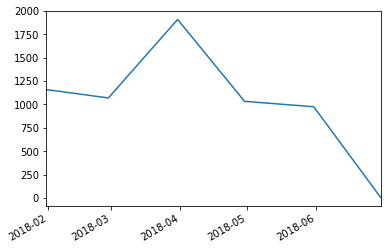

In [77]:
summary['report_dt'].value_counts().plot()

## Merge Lipper_class onto returns data

### Merge does not take dates into account -> TODO

In [78]:
summary.dtypes

port_no                  int64
report_dt       datetime64[ns]
fund_name               object
avrcs                  float64
lipper_class            object
False                   object
cap_class               object
style_class             object
fund_no                  int64
date            datetime64[ns]
dtype: object

In [79]:
returns.head(1)

,crsp_fundno,caldt,mret,date
180,105.0,2018-01-31,0.042781,2018-01-31


In [80]:
returns_merged = returns.merge(summary, how='left', left_on=['crsp_fundno'],right_on=['fund_no'])
returns_merged.shape

(150283, 14)

In [81]:
returns_merged = returns_merged.drop(columns=['report_dt','fund_no'])

In [82]:
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged.shape

(70254, 12)

#### Take only needed columns and reorder them

In [83]:
returns_merged = returns_merged[['port_no','caldt','mret','lipper_class','style_class','cap_class']]

In [84]:
returns_merged.sample()

,port_no,caldt,mret,lipper_class,style_class,cap_class
39178,1027276.0,2018-02-28,-0.031179,LCCE,C,L


## Check for how many funds returns data is available

#### TODO

## Calc mean return per Obj_cd

### Get unique codes for later

In [85]:
group_by = 'style_class'

In [86]:
obj_codes = returns_merged[[group_by]].drop_duplicates()
obj_codes = obj_codes[group_by].values
obj_codes

array(['C', 'G', 'V'], dtype=object)

In [87]:
# Analysis of selected funds
returns_obj = returns_merged.groupby([group_by,'caldt'])['mret'].agg(['mean','count','std'])

In [88]:
def cumreturn(series):
    """
    Calculate cumreturn from a pandas series
    
    Attention: Sets first return observation to 1
    Could be better implemented
    """
    min_date = series.index.min()
    series.loc[min_date] = 0
    series = (series.fillna(0)+1).cumprod()
    return(series)

In [89]:
returns_obj['cumret'] = returns_obj.groupby(group_by)[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [90]:
returns_obj_n = returns_obj.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns=group_by)

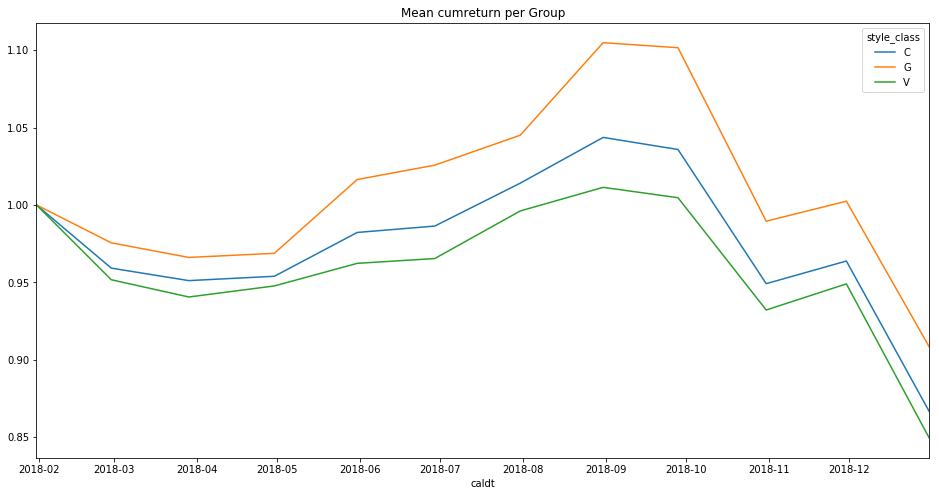

In [91]:
returns_obj_n.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Cluster with k-means

#### Metaparameter number of clusters

In [93]:
transformer = MaxAbsScaler().fit(holdings) # fit does nothing.
transformer

MaxAbsScaler(copy=True)

In [94]:
holdings = transformer.transform(holdings)

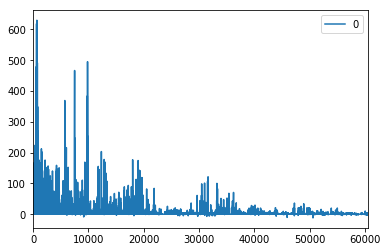

In [95]:
pd.DataFrame(holdings.sum(0)).T.plot()

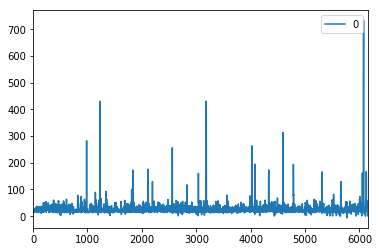

In [96]:
pd.DataFrame(holdings.sum(1)).plot()

In [105]:
print('Start kMeans...')
kmeans = KMeans(n_clusters = 3,
                verbose = True,
                n_init = 10, # Number of runs
                n_jobs= -1,
                random_state=123).fit(holdings)

Start kMeans...


In [148]:
labels = pd.DataFrame(kmeans.labels_)

In [107]:
summary['cluster'] = lables.values

In [115]:
round(pd.crosstab(summary['cap_class'],summary['cluster'], margins = True, normalize = 'columns') * 100, 2)

cluster,0,1,2,All
cap_class,,,,
L,2.28,67.58,61.61,34.48
M,41.79,32.42,38.34,38.83
S,55.93,0.00,0.05,26.69


In [116]:
round(pd.crosstab(summary['style_class'],summary['cluster'], margins = True, normalize = 'columns') * 100, 2)

cluster,0,1,2,All
style_class,,,,
C,50.48,9.25,59.73,45.48
G,34.81,90.75,1.98,34.95
V,14.71,0.00,38.29,19.58


## Chart the returns of the formed clustes

In [39]:
summary.sample()

,port_no,report_dt,fund_name,avrcs,lipper_class,False,cap_class,style_class,fund_no,date,cluster
144442,1028439,2018-02-28,TIAA-CREF Funds: Quant Large-Cap Value Fund; I...,98.459333,MLVE,LCVE,M,V,36607.0,2018-02-28,1


#### Merge new clusters into returns

In [40]:
returns_merged = returns.merge(summary, how='left', left_on='crsp_fundno',right_on='fund_no')
returns_merged = returns_merged.dropna(axis = 0, how = 'any')
returns_merged = returns_merged[['caldt','fund_no','port_no','mret','lipper_class','cluster']]
returns_merged.sample()

,caldt,fund_no,port_no,mret,lipper_class,cluster
4525,2018-04-30,4532.0,1021047.0,-0.015705,MCGE,0.0


#### Calc mean return per Obj_cd

In [41]:
cluster_codes = returns_merged[['cluster']].drop_duplicates()
cluster_codes = cluster_codes['cluster'].values
cluster_codes

array([0., 1., 2., 3.])

In [42]:
# Analysis of selected funds
returns_clus = returns_merged.groupby(['cluster','caldt'])['mret'].agg(['mean','count','std'])
returns_clus['cumret'] = returns_clus.groupby('cluster')[['mean']].apply(cumreturn)

#### Pivot to make multiple columns, one for each obj_cd

In [43]:
returns_clus = returns_clus.pivot_table(
        values='cumret', 
        index=['caldt'], 
        columns='cluster')

returns_clus.plot(
              kind='line',
              use_index=True,
              figsize=(16,8),
              title='Mean cumreturn per Group',
              legend='best')

## Analysing clusters

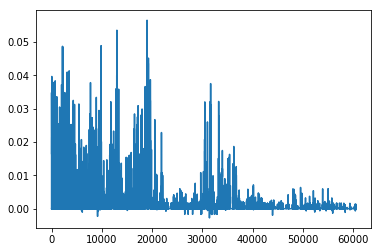

In [122]:
plt.plot(kmeans.cluster_centers_[0,:])

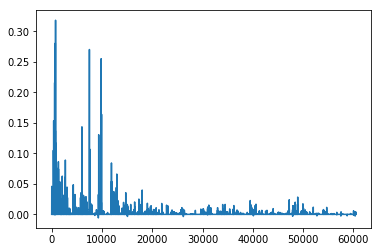

In [123]:
plt.plot(kmeans.cluster_centers_[1,:])

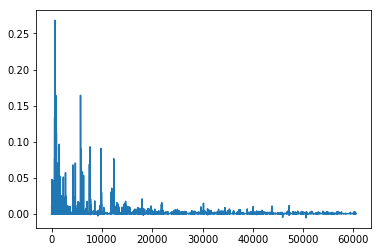

In [124]:
plt.plot(kmeans.cluster_centers_[2,:])

## PCA

In [140]:
pca = PCA(n_components=10)
pca.fit(holdings.toarray())  

print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[0.03635428 0.0250854  0.02393638 0.01603034 0.01216977 0.01116698
 0.01076683 0.01004388 0.00884454 0.00799503]
[50.12177341 41.63505791 40.67035325 33.2828139  28.99946064 27.77900124
 27.27674804 26.34507978 24.72214906 23.50491873]


In [171]:
df = pd.DataFrame(pca.components_).T
df = pd.DataFrame({
    'pca_1' : df.iloc[:,0],
    'pca_2' : df.iloc[:,1],
    'labels' : labels.iloc[:,0]
})

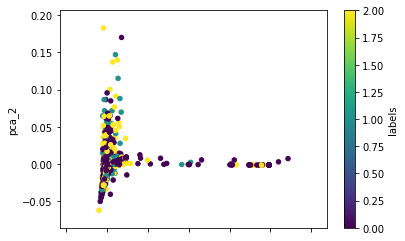

In [172]:
df.plot.scatter(x='pca_1',
                y='pca_2',
                c='labels',
                colormap='viridis')

In [175]:
import pandas as pd
df = pd.read_csv('http://www.stat.ubc.ca/~jenny/notOcto/STAT545A/examples/gapminder/data/gapminderDataFiveYear.txt', sep='\t')
df2007 = df[df.year==2007]
df1952 = df[df.year==1952]
df.head(2)

fig = {
    'data': [
  		{
  			'x': df2007.gdpPercap, 
        	'y': df2007.lifeExp, 
        	'text': df2007.country, 
        	'mode': 'markers', 
        	'name': '2007'},
        {
        	'x': df1952.gdpPercap, 
        	'y': df1952.lifeExp, 
        	'text': df1952.country, 
        	'mode': 'markers', 
        	'name': '1952'}
    ],
    'layout': {
        'xaxis': {'title': 'GDP per Capita', 'type': 'log'},
        'yaxis': {'title': "Life Expectancy"}
    }
}

# IPython notebook
py.iplot(fig, filename='pandas/multiple-scatter')

NameError: name 'py' is not defined

# Visualize

In [45]:
MiniBatchKMeans?

For n_clusters = 2 The average silhouette_score is : 0.6230974691544068
For n_clusters = 3 The average silhouette_score is : -0.022274616659674784
For n_clusters = 4 The average silhouette_score is : -0.001094342189072827
For n_clusters = 5 The average silhouette_score is : -0.019420490441290388


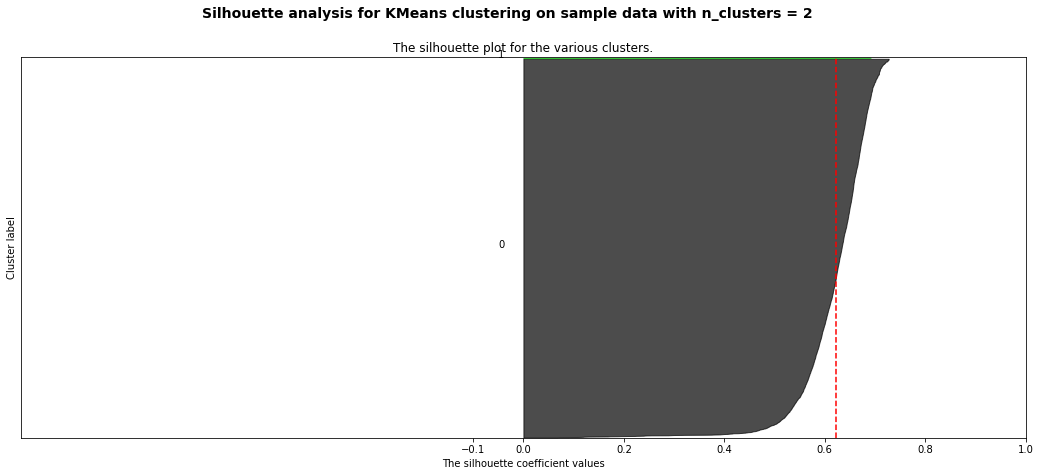

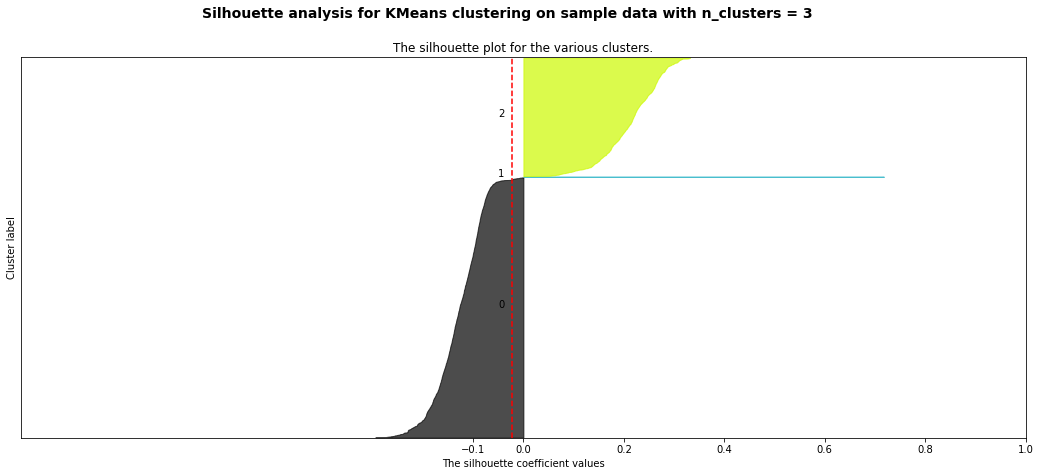

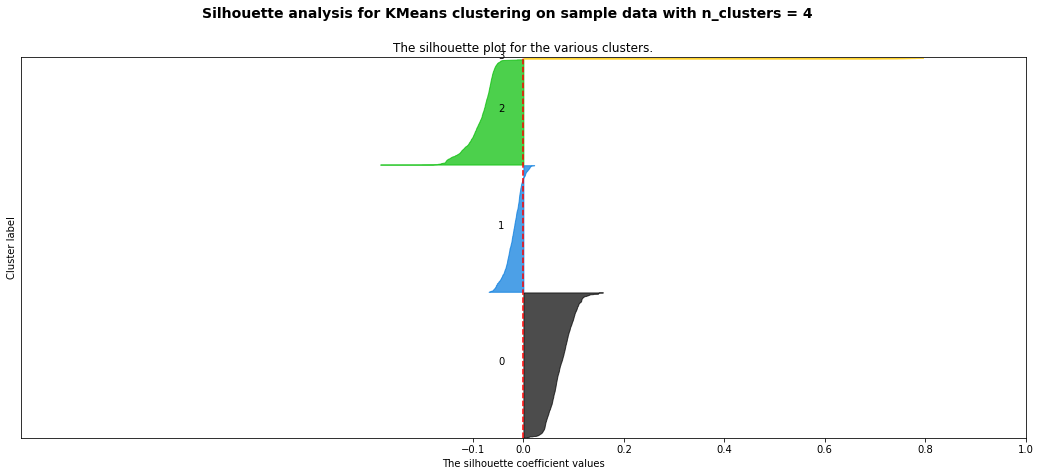

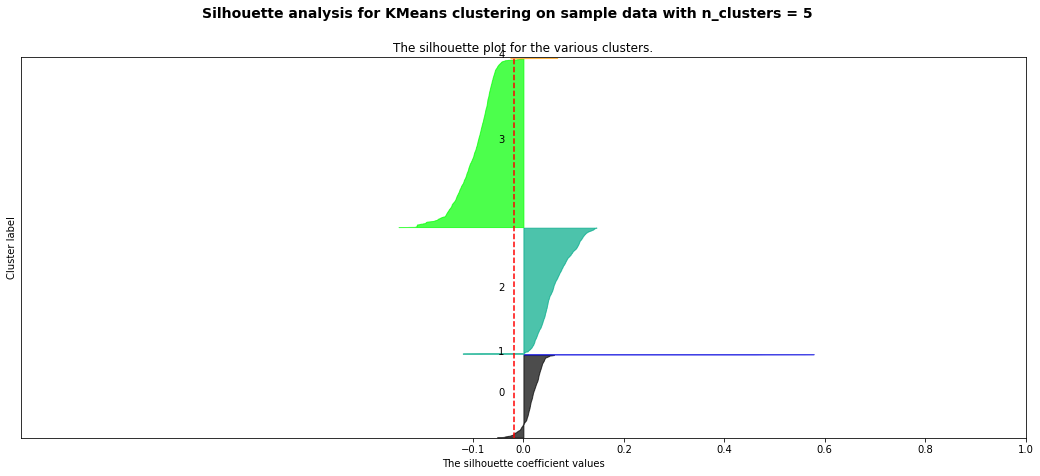

In [47]:
### Based on example code from sklearn ###

X = holdings
n_clusters = [2,3,4,5]

clusters = []
results = []

for n_clusters in n_clusters:
    clusterer = MiniBatchKMeans(
                    n_clusters=n_clusters,
                    verbose = False,
                    n_init = 1000)
    
    
    cluster_fit = clusterer.fit(holdings)
    clusters.append(n_clusters)
    results.append(cluster_fit.inertia_)    
    
    cluster_labels = cluster_fit.labels_
    
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample

    # TODO can pool.map be implemented here?
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()